# Ames, Iowa : Predicting Sales Prices - Penalized Linear Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler,\
MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from LR_helper import cat_column_combine_vars, num_new_features,\
label_encode_features, model_results, cat_new_features, std_num_cols
from clean_helper import dtype_update
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

### Loading cleaned training and testing datasets:-

In [2]:
train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)
print(train_df.shape)
print(test_df.shape)

(1453, 80)
(1457, 79)


- Creating copies to apply diffrent transformations and engineering techniques:

In [3]:
train_df_cpy = train_df.copy()
test_df_cpy = test_df.copy()
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 80)
(1457, 79)


### Creating new numerical variables, combining variables and creating new categorical variables:-

In [4]:
# Creating new numerical variable features:-
num_new_features(train_df)
num_new_features(test_df)
num_new_features(train_df_cpy)
num_new_features(test_df_cpy)

# Combining categories in some categorical features:-
cat_column_combine_vars(train_df)
cat_column_combine_vars(test_df)
cat_column_combine_vars(train_df_cpy)
cat_column_combine_vars(test_df_cpy)

# Creating new categorical variable features:-
cat_new_features(train_df)
cat_new_features(test_df)
cat_new_features(train_df_cpy)
cat_new_features(test_df_cpy)

In [5]:
print(train_df.shape)
print(test_df.shape)
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 88)
(1457, 87)
(1453, 88)
(1457, 87)


### In-depth EDA to research relationship with Sales Price

#### 1. Finished Basement relation to Sale Prices

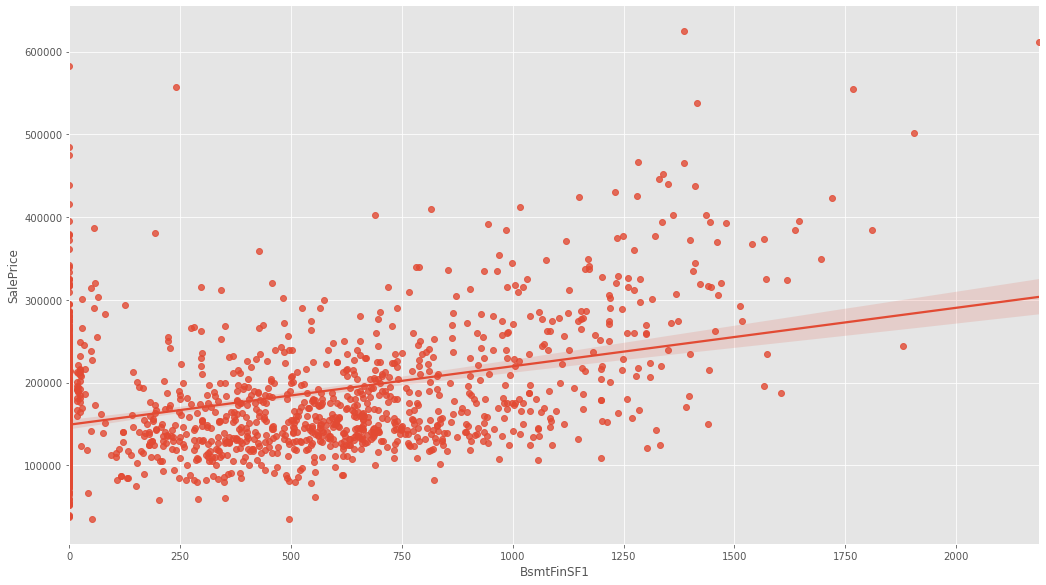

In [6]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

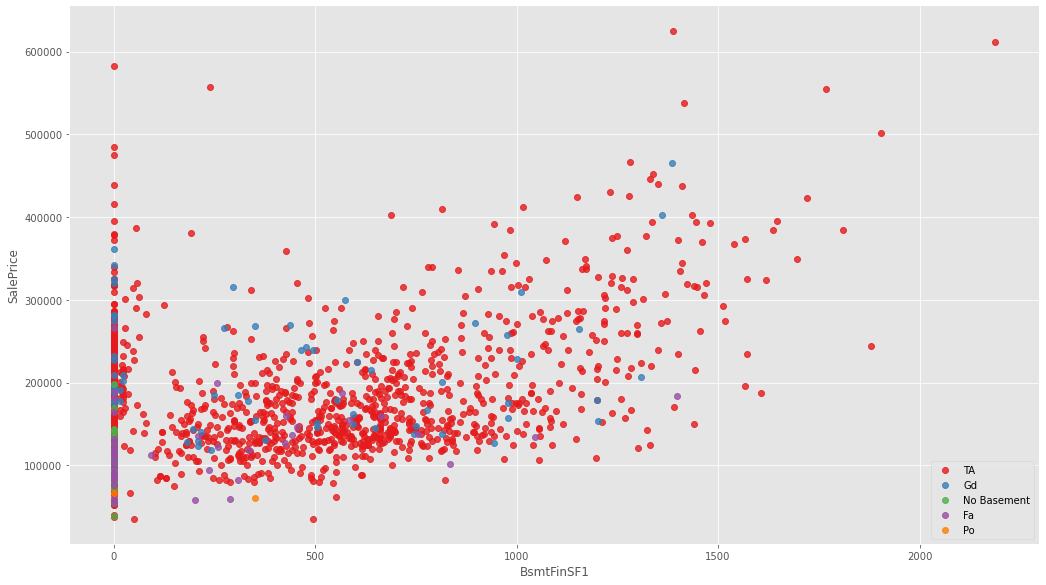

In [7]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtCond', legend=False)
plt.legend(loc='lower right')

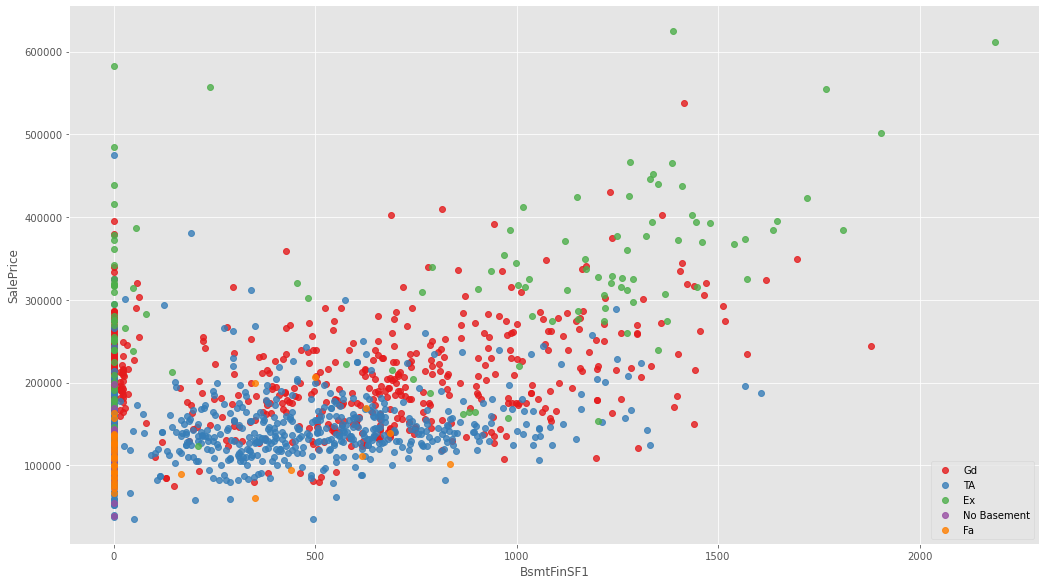

In [8]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtQual', legend=False)
plt.legend(loc='lower right')

#### 2. Above ground living area

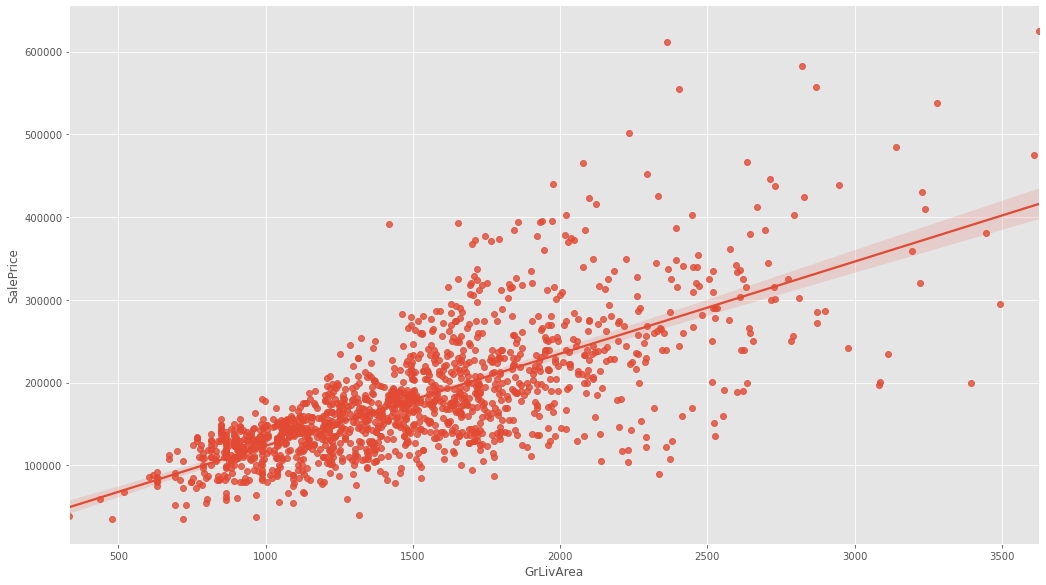

In [9]:
sns.lmplot("GrLivArea", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

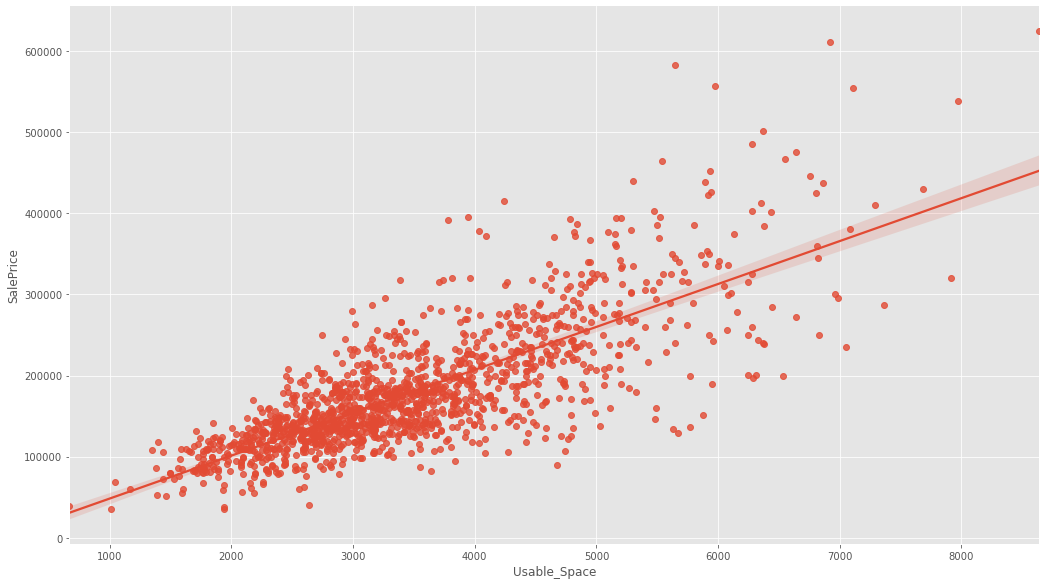

In [10]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

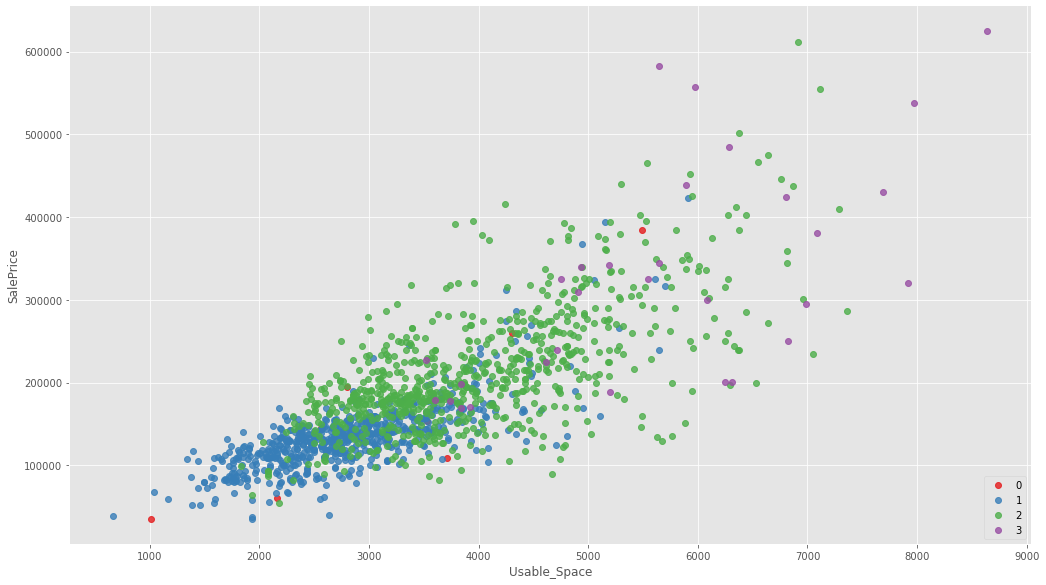

In [11]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='FullBath', legend=False)
plt.legend(loc='lower right')

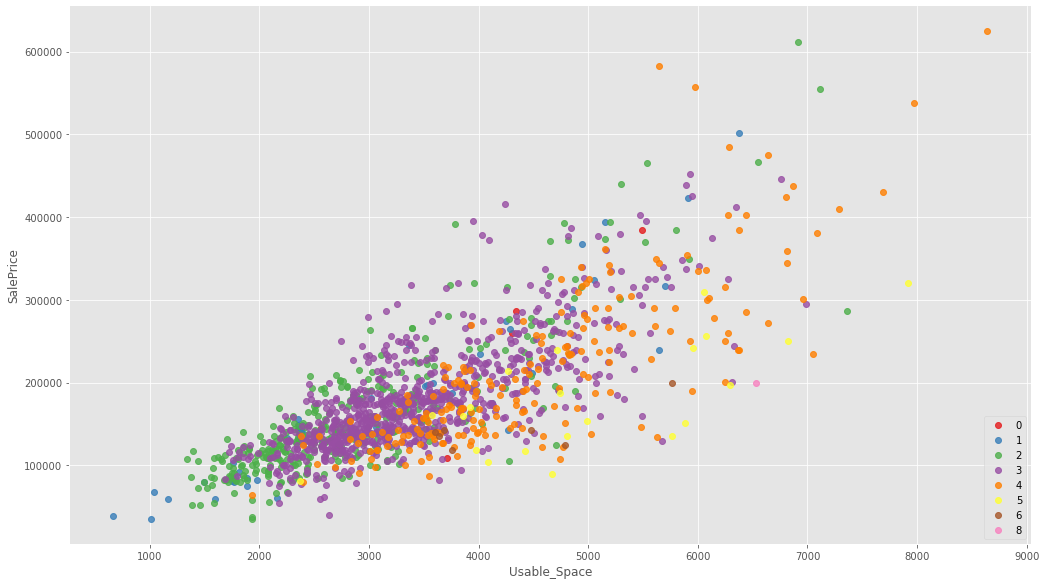

In [12]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BedroomAbvGr', legend=False)
plt.legend(loc='lower right')

#### 4. Years since remodeled and remodeled or not

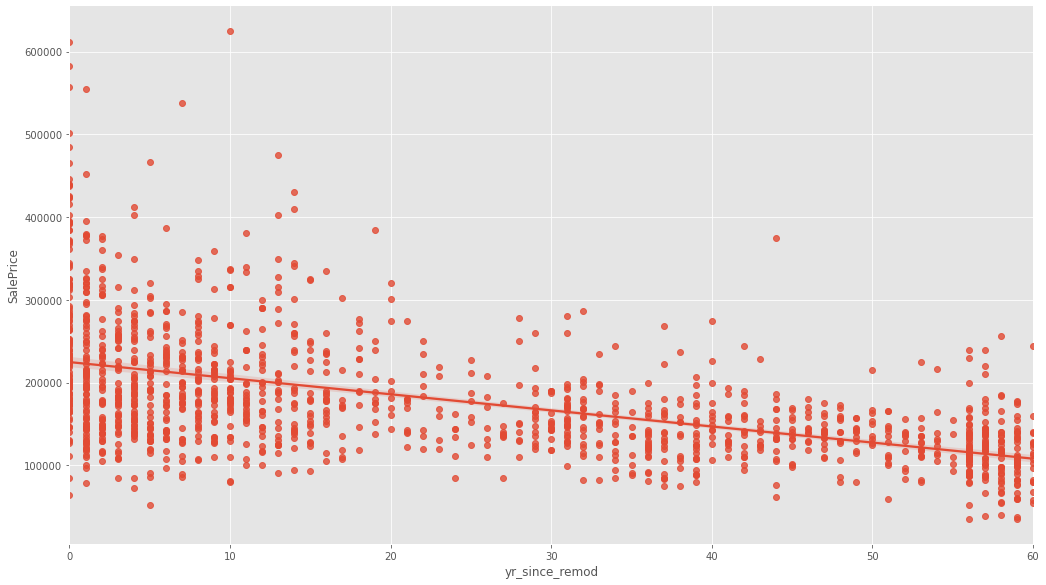

In [13]:
sns.lmplot("yr_since_remod", "SalePrice", train_df, height=8, aspect=1.8, palette="Pastel1")

Text(0.5, 1.0, 'House Price vs Years Since Remodeled')

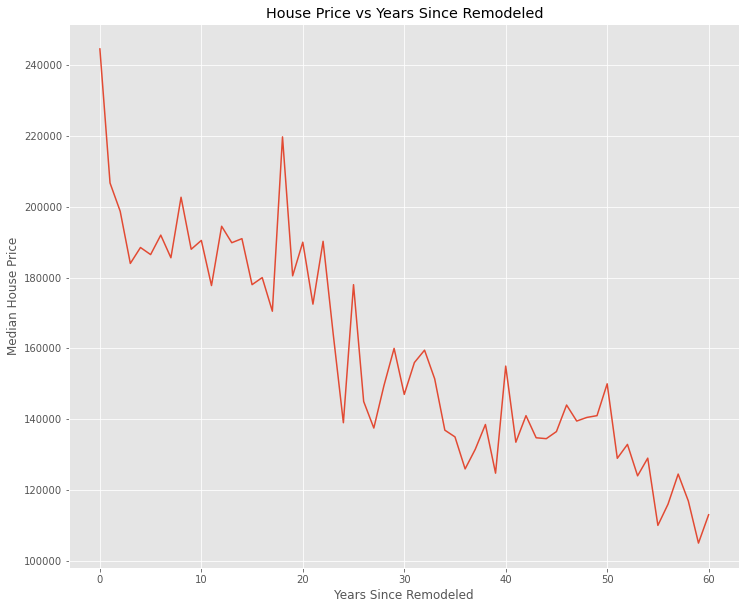

In [14]:
plt.figure(figsize = (12,10))
train_df.groupby('yr_since_remod')['SalePrice'].median().plot()
plt.xlabel('Years Since Remodeled')
plt.ylabel('Median House Price')
plt.title("House Price vs Years Since Remodeled")

<AxesSubplot:xlabel='remod_y_n', ylabel='SalePrice'>

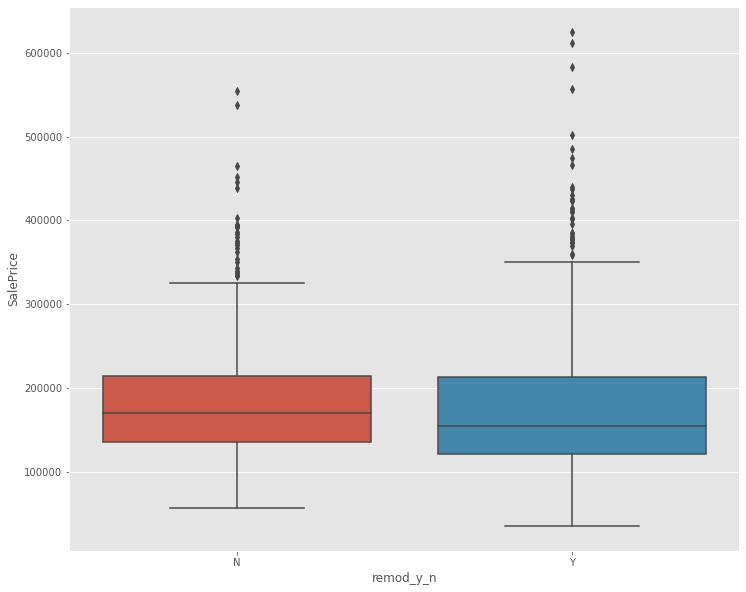

In [15]:
plt.figure(figsize = (12,10))
my_order = train_df.groupby('remod_y_n')['SalePrice']\
           .median().sort_values(ascending=False).index
sns.boxplot(data=train_df, x='remod_y_n', y='SalePrice', order=my_order)

### Label encoding categorical features (all dataframes):

In [16]:
#Label encoding via helper functions:-

label_encode_features(train_df)
label_encode_features(test_df)
label_encode_features(train_df_cpy)
label_encode_features(test_df_cpy)

### OneHot encoding categorical features (all dataframes):

In [17]:
col_list = ['Street', 'Alley', 'LandContour','RoofStyle','Exterior1st','MSZoning',\
            'Utilities', 'LotConfig','Neighborhood', 'Condition1', 'Condition2',\
            'BldgType', 'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'Foundation','MasVnrType',\
            'CentralAir','Heating', 'Electrical', 'Functional','Exterior2nd','GarageType',\
            'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold',\
            'SaleType', 'SaleCondition','remod_y_n', 'HouseStyle', 'MSSubClass']

train_df = pd.get_dummies(data=train_df, columns=col_list, drop_first=True)
test_df = pd.get_dummies(data=test_df, columns=col_list, drop_first=True)

train_df_cpy = pd.get_dummies(data=train_df_cpy, columns=col_list, drop_first=True)
test_df_cpy = pd.get_dummies(data=test_df_cpy, columns=col_list, drop_first=True)

### Standardizing numerical columns:

- Only for the copies of test and train dfs

In [18]:
std_num_cols(train_df_cpy)
std_num_cols(test_df_cpy)

## Ridge Regression Models:-

In [19]:
## Separating x and y variables for test-train split (main df)

house_x = train_df.drop(['SalePrice'], axis=1)
house_y = train_df['SalePrice']

## Separating x and y variables for test-train split (copy df)

house_x_cpy = train_df_cpy.drop(['SalePrice'], axis=1)
house_y_cpy = train_df_cpy['SalePrice']

# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(house_x, house_y, random_state=42, test_size=0.3)
trainXcp, testXcp, trainYcp, testYcp = train_test_split(house_x_cpy, house_y_cpy, random_state=42, test_size=0.3)

### 1. Adjusting standardization/normalisation and alpha levels

In [20]:
# Numerical columns standardized:

ridge_base12 = Ridge()
model_results(trainXcp, trainYcp, testXcp, testYcp, ridge_base12, show = True)

Train R^2 is equal to 0.948
Test R^2 is equal to 0.875
The intercept is -52730.009
RSS is equal to 323530906525.948
RMSE is equal to 17835.998
The training error is: 0.05208
The test     error is: 0.12486


[0.05207656708342401, 0.1248632933167334]

In [21]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base11 = Ridge()
model_results(trainX, trainY, testX, testY, ridge_base11, show = True)

Train R^2 is equal to 0.948
Test R^2 is equal to 0.875
The intercept is -52730.009
RSS is equal to 323530906525.948
RMSE is equal to 17835.998
The training error is: 0.05208
The test     error is: 0.12486


[0.05207656708342401, 0.1248632933167334]

In [22]:
# Numerical columns not standardized (normalization is turned on):

ridge_base13 = Ridge()
ridge_base13.set_params(normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base13, show = True)

Train R^2 is equal to 0.916
Test R^2 is equal to 0.887
The intercept is -64280.126
RSS is equal to 520635563664.171
RMSE is equal to 22625.930
The training error is: 0.08380
The test     error is: 0.11262


[0.08380316164631696, 0.11262098279840627]

In [23]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base14 = Ridge()
ridge_base14.set_params(alpha = 0, normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base14, show = True)

Train R^2 is equal to 0.951
Test R^2 is equal to -237795004321107076448256.000
The intercept is 815389210490035712.000
RSS is equal to 304469994302.000
RMSE is equal to 17302.616
The training error is: 0.04901
The test     error is: 237795004321107076448256.00000


[0.04900846182955376, 2.3779500432110708e+23]

### 2. Log-transforming y variable only:

In [24]:
# Numerical columns standardized:

ridge_base22 = Ridge()
model_results(trainXcp, np.log(trainYcp), testXcp, np.log(testYcp), ridge_base22, show = True)

Train R^2 is equal to 0.959
Test R^2 is equal to 0.893
The intercept is 10.874
RSS is equal to 6.557
RMSE is equal to 0.080
The training error is: 0.04053
The test     error is: 0.10697


[0.04052962948695327, 0.10696836075327854]

In [25]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base21 = Ridge()
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base21, show = True)

Train R^2 is equal to 0.959
Test R^2 is equal to 0.893
The intercept is 10.874
RSS is equal to 6.557
RMSE is equal to 0.080
The training error is: 0.04053
The test     error is: 0.10697


[0.04052962948695327, 0.10696836075327854]

In [26]:
# Numerical columns not standardized (normalization is turned on):

ridge_base23 = Ridge()
ridge_base23.set_params(normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base23, show = True)

Train R^2 is equal to 0.930
Test R^2 is equal to 0.894
The intercept is 10.455
RSS is equal to 11.270
RMSE is equal to 0.105
The training error is: 0.06966
The test     error is: 0.10566


[0.06966425032875789, 0.1056640464704196]

In [27]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base24 = Ridge()
ridge_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base24, show = True)

Train R^2 is equal to 0.962
Test R^2 is equal to -192724403846759760003072.000
The intercept is 3908741159368.891
RSS is equal to 6.084
RMSE is equal to 0.077
The training error is: 0.03761
The test     error is: 192724403846759760003072.00000


[0.03760890474861678, 1.9272440384675976e+23]

### 3. Log-transforming x and y variables:

In [28]:
# Applying log-transformation on the x features (both datasets)

trfm = FunctionTransformer(func=np.log1p)

trainX_trans = trfm.fit_transform(trainX)
trainXcp_trans = trfm.fit_transform(trainXcp)
testX_trans = trfm.fit_transform(testX)
testXcp_trans = trfm.fit_transform(testXcp)

In [29]:
# Numerical columns standardized:

ridge_base32 = Ridge()
model_results(trainXcp_trans, np.log(trainYcp), testXcp_trans, np.log(testYcp), ridge_base32, show = True)

Train R^2 is equal to 0.954
Test R^2 is equal to 0.897
The intercept is 6.096
RSS is equal to 7.513
RMSE is equal to 0.086
The training error is: 0.04644
The test     error is: 0.10341


[0.046437721335038096, 0.1034074703648401]

In [30]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base31 = Ridge()
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base31, show = True)

Train R^2 is equal to 0.954
Test R^2 is equal to 0.897
The intercept is 6.096
RSS is equal to 7.513
RMSE is equal to 0.086
The training error is: 0.04644
The test     error is: 0.10341


[0.046437721335038096, 0.1034074703648401]

In [31]:
# Numerical columns not standardized (normalization is turned on):

ridge_base33 = Ridge()
ridge_base33.set_params(normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base33, show = True)

Train R^2 is equal to 0.925
Test R^2 is equal to 0.888
The intercept is 3.523
RSS is equal to 12.059
RMSE is equal to 0.109
The training error is: 0.07454
The test     error is: 0.11189


[0.07454177743084822, 0.11188962277526715]

In [32]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base34 = Ridge()
ridge_base34.set_params(alpha = 0, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base34, show = True)

Train R^2 is equal to 0.960
Test R^2 is equal to -597362642738389027127296.000
The intercept is -5850635802171.333
RSS is equal to 6.395
RMSE is equal to 0.079
The training error is: 0.03953
The test     error is: 597362642738389027127296.00000


[0.03952777523963369, 5.97362642738389e+23]

### Visualzing errors for first three models of the last section

- Numerical columns are standardized in this model:

(array([  3.,   2.,   1.,   6.,  43., 196., 505., 220.,  35.,   6.]),
 array([-0.57564938, -0.48684179, -0.3980342 , -0.30922661, -0.22041902,
        -0.13161143, -0.04280384,  0.04600375,  0.13481134,  0.22361893,
         0.31242652]),
 <BarContainer object of 10 artists>)

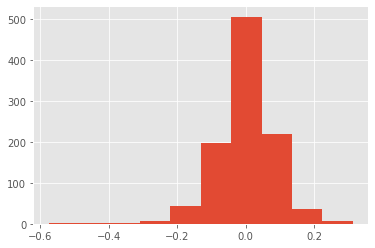

In [33]:
residuals = np.log(trainYcp) - ridge_base32.predict(trainXcp_trans)
plt.hist(residuals)

- Numerical columns are not standardized and normalization is not turned on

(array([  3.,   2.,   1.,   6.,  43., 196., 505., 220.,  35.,   6.]),
 array([-0.57564938, -0.48684179, -0.3980342 , -0.30922661, -0.22041902,
        -0.13161143, -0.04280384,  0.04600375,  0.13481134,  0.22361893,
         0.31242652]),
 <BarContainer object of 10 artists>)

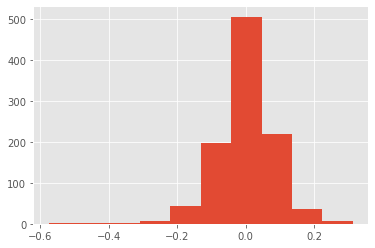

In [34]:
residuals = np.log(trainY) - ridge_base31.predict(trainX_trans)
plt.hist(residuals)

- Numerical columns are not standardized and normalization is turned on

(array([  3.,   2.,   6.,  19.,  78., 353., 410., 123.,  17.,   6.]),
 array([-0.64702164, -0.54044804, -0.43387444, -0.32730084, -0.22072723,
        -0.11415363, -0.00758003,  0.09899357,  0.20556718,  0.31214078,
         0.41871438]),
 <BarContainer object of 10 artists>)

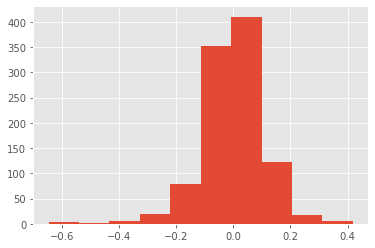

In [35]:
residuals = np.log(trainY) - ridge_base33.predict(trainX_trans)
plt.hist(residuals)

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [36]:
alphas = np.arange(0,20)
scores = []

for alpha in alphas:
        ridge_base32.set_params(alpha=alpha)
        ridge_base32.fit(trainXcp_trans, np.log(trainYcp))  
        scores.append(ridge_base32.score(trainXcp_trans, np.log(trainYcp)))

Text(0, 0.5, '$R^2$')

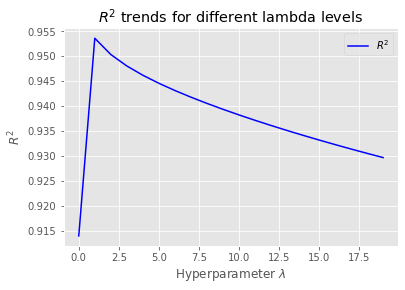

In [37]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [38]:
alphas = np.arange(0,20)
ridge_base33.set_params(normalize=True)
scores = []

for alpha in alphas:
        ridge_base33.set_params(alpha=alpha)
        ridge_base33.fit(trainX_trans, np.log(trainY))  
        scores.append(ridge_base33.score(trainX_trans, np.log(trainY)))

Text(0, 0.5, '$R^2$')

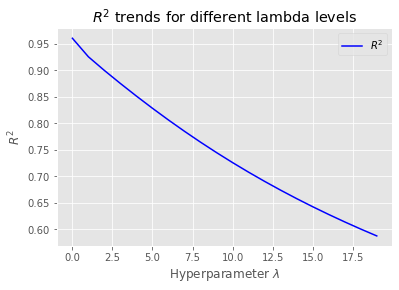

In [39]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')